<a href="https://colab.research.google.com/github/kimjjoy2/NSMC/blob/main/NSMC_KoELECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 11.66 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [2]:
# transformers 설치
! pip install transformers

     |████████████████████████████████| 1.5MB 13.8MB/s 
     |████████████████████████████████| 2.9MB 54.3MB/s 
     |████████████████████████████████| 890kB 72.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4021327ff987ddd10549998ba5345cf79d91569f7cc70d4b3e1f8a0143fabd2c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# import
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [4]:
# GPU 셑팅
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [5]:
# tokenizer, model 설치
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator").to(device)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [6]:
import re

def text_cleansing(text):
  # E-mail 제거
  pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)'
  text = re.sub(pattern=pattern, repl=' ', string=text)

  # Url 제거
  pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  text = re.sub(pattern=pattern, repl=' ', string=text)

  # 한글 자음, 모음 제거
  #pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'
  #text = re.sub(pattern=pattern, repl=' ', string=text)

  # \r, \n 제거
  pattern = '[\r|\n]'
  text = re.sub(pattern=pattern, repl=' ', string=text)
                
  # 특수문자 제거
  pattern = '[^\w\s]'
  text = re.sub(pattern=pattern, repl=' ', string=text)

  # 마지막으로 중복 스페이스 제거
  pattern = re.compile(r'\s+')
  text = re.sub(pattern=pattern, repl=' ', string=text)
                
  return text

In [7]:
text_cleansing('http://blog.naver.com/oroblast/220215679580 나쁜 인상은 아니지만 ㅋㅋ,\
                오랫동안 기억에 남아 ㅠㅠ 종종 떠올라서....조금은 사람을 피곤하게 만드는 영화. ^^')

' 나쁜 인상은 아니지만 ㅋㅋ 오랫동안 기억에 남아 ㅠㅠ 종종 떠올라서 조금은 사람을 피곤하게 만드는 영화 '

In [8]:
# 전처리
## NaN, 중복 제거
class NSMCDataset(Dataset):
  
  def __init__(self, csv_file, sep, dup_field='document'):
  
    self.dataset = pd.read_csv(csv_file, sep=sep).dropna(axis=0) 
    if dup_field:
      self.dataset.drop_duplicates(subset=[dup_field], inplace=True)
    self.tokenizer = tokenizer

    print(self.dataset.describe())
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 1:].values
    text = text_cleansing(row[0])

    if len(row) < 2:
      y = 0
    else:
      y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [9]:
# train, test dataset 준비
train_dataset = NSMCDataset("/content/nsmc/ratings_train.txt", '\t')
test_dataset = NSMCDataset("/content/nsmc/ratings_test.txt", '\t')
train_dataset[0]

                 id          label
count  1.461820e+05  146182.000000
mean   6.779186e+06       0.498283
std    2.919223e+06       0.499999
min    3.300000e+01       0.000000
25%    4.814832e+06       0.000000
50%    7.581160e+06       0.000000
75%    9.274760e+06       1.000000
max    1.027815e+07       1.000000
                 id         label
count  4.915700e+04  49157.000000
mean   6.752945e+06      0.502695
std    2.937158e+06      0.499998
min    6.010000e+02      0.000000
25%    4.777143e+06      0.000000
50%    7.565415e+06      1.000000
75%    9.260204e+06      1.000000
max    1.027809e+07      1.000000


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(tensor([    2,  3079, 33345,  7082, 13215,  4065,  4116,  4150,  6933,     3,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [10]:
# Train 환경 설정
epochs = 5
batch_size = 128
optimizer = AdamW(model.parameters(), lr=1e-5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [11]:
#Training

losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Batch Loss: 68.90445077419281 Accuracy: tensor(0.5648, device='cuda:0')
Batch Loss: 128.74745148420334 Accuracy: tensor(0.6564, device='cuda:0')
Batch Loss: 178.45100605487823 Accuracy: tensor(0.7011, device='cuda:0')
Batch Loss: 223.74554735422134 Accuracy: tensor(0.7283, device='cuda:0')
Batch Loss: 266.8933810889721 Accuracy: tensor(0.7452, device='cuda:0')
Batch Loss: 308.3980932831764 Accuracy: tensor(0.7578, device='cuda:0')
Batch Loss: 349.29185032844543 Accuracy: tensor(0.7668, device='cuda:0')
Batch Loss: 388.1958577632904 Accuracy: tensor(0.7746, device='cuda:0')
Batch Loss: 426.200033724308 Accuracy: tensor(0.7812, device='cuda:0')
Batch Loss: 464.0838332474232 Accuracy: tensor(0.7864, device='cuda:0')
Batch Loss: 501.26359713077545 Accuracy: tensor(0.7911, device='cuda:0')

Train Loss: 517.1126987636089 Accuracy: tensor(0.7931, device='cuda:0')


Batch Loss: 35.24152083694935 Accuracy: tensor(0.8471, device='cuda:0')
Batch Loss: 70.8954634219408 Accuracy: tensor(0.8461, device='cuda:0')
Batch Loss: 106.11249803006649 Accuracy: tensor(0.8462, device='cuda:0')
Batch Loss: 140.63906946778297 Accuracy: tensor(0.8471, device='cuda:0')
Batch Loss: 174.68159593641758 Accuracy: tensor(0.8483, device='cuda:0')
Batch Loss: 209.00388997793198 Accuracy: tensor(0.8489, device='cuda:0')
Batch Loss: 242.51384368538857 Accuracy: tensor(0.8496, device='cuda:0')
Batch Loss: 276.35834757983685 Accuracy: tensor(0.8502, device='cuda:0')
Batch Loss: 309.6046033501625 Accuracy: tensor(0.8507, device='cuda:0')
Batch Loss: 342.6036779731512 Accuracy: tensor(0.8511, device='cuda:0')
Batch Loss: 375.849378913641 Accuracy: tensor(0.8513, device='cuda:0')

Train Loss: 390.1431217342615 Accuracy: tensor(0.8515, device='cuda:0')


Batch Loss: 31.665540754795074 Accuracy: tensor(0.8627, device='cuda:0')
Batch Loss: 62.84718310832977 Accuracy: tensor(0.8633, device='cuda:0')
Batch Loss: 93.62293776869774 Accuracy: tensor(0.8655, device='cuda:0')
Batch Loss: 125.71409490704536 Accuracy: tensor(0.8646, device='cuda:0')
Batch Loss: 157.1772761642933 Accuracy: tensor(0.8650, device='cuda:0')
Batch Loss: 187.98994466662407 Accuracy: tensor(0.8659, device='cuda:0')
Batch Loss: 219.5831603705883 Accuracy: tensor(0.8659, device='cuda:0')
Batch Loss: 250.87273652851582 Accuracy: tensor(0.8659, device='cuda:0')
Batch Loss: 281.01843927800655 Accuracy: tensor(0.8666, device='cuda:0')
Batch Loss: 312.84424164891243 Accuracy: tensor(0.8663, device='cuda:0')
Batch Loss: 343.59199026227 Accuracy: tensor(0.8665, device='cuda:0')

Train Loss: 356.6826243251562 Accuracy: tensor(0.8668, device='cuda:0')


Batch Loss: 29.748911276459694 Accuracy: tensor(0.8752, device='cuda:0')
Batch Loss: 59.24768151342869 Accuracy: tensor(0.8734, device='cuda:0')
Batch Loss: 88.79007433354855 Accuracy: tensor(0.8733, device='cuda:0')
Batch Loss: 117.6190966963768 Accuracy: tensor(0.8747, device='cuda:0')
Batch Loss: 147.18685576319695 Accuracy: tensor(0.8748, device='cuda:0')
Batch Loss: 176.17862294614315 Accuracy: tensor(0.8748, device='cuda:0')
Batch Loss: 205.99139538407326 Accuracy: tensor(0.8738, device='cuda:0')
Batch Loss: 235.4245893508196 Accuracy: tensor(0.8739, device='cuda:0')
Batch Loss: 264.49416452646255 Accuracy: tensor(0.8739, device='cuda:0')
Batch Loss: 293.9266878962517 Accuracy: tensor(0.8741, device='cuda:0')
Batch Loss: 323.3361682742834 Accuracy: tensor(0.8745, device='cuda:0')

Train Loss: 336.01839342713356 Accuracy: tensor(0.8745, device='cuda:0')


Batch Loss: 28.87236289680004 Accuracy: tensor(0.8785, device='cuda:0')
Batch Loss: 56.20431549847126 Accuracy: tensor(0.8802, device='cuda:0')
Batch Loss: 84.77188219130039 Accuracy: tensor(0.8809, device='cuda:0')
Batch Loss: 112.62619605660439 Accuracy: tensor(0.8813, device='cuda:0')
Batch Loss: 140.5462084710598 Accuracy: tensor(0.8816, device='cuda:0')
Batch Loss: 168.71123369038105 Accuracy: tensor(0.8814, device='cuda:0')
Batch Loss: 196.10925437510014 Accuracy: tensor(0.8818, device='cuda:0')
Batch Loss: 224.1805823892355 Accuracy: tensor(0.8815, device='cuda:0')
Batch Loss: 250.6187917739153 Accuracy: tensor(0.8822, device='cuda:0')
Batch Loss: 278.9399567991495 Accuracy: tensor(0.8820, device='cuda:0')
Batch Loss: 306.4990208745003 Accuracy: tensor(0.8820, device='cuda:0')

Train Loss: 318.29638400673866 Accuracy: tensor(0.8821, device='cuda:0')


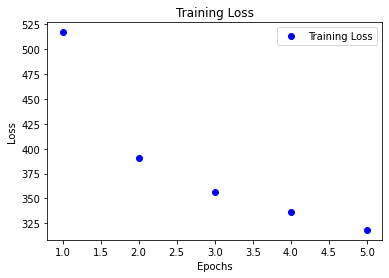

In [24]:
import matplotlib.pyplot as plt

acc = accuracies
loss = losses

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
#plt.plot(epochs, acc, 'b', label='Training acc')
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

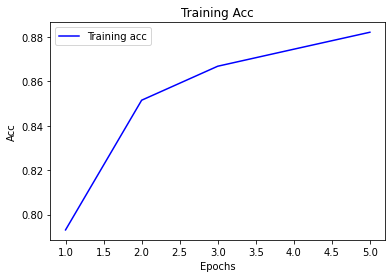

In [26]:
import matplotlib.pyplot as plt

acc = accuracies
loss = losses

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.title("Training Acc")
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [12]:
# Test

model.eval()

test_correct = 0
test_total = 0
seq= 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  
  _, predicted = torch.max(y_pred, 1)

  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

  seq += 1
  #if seq>100: break

print("Accuracy:", test_correct.float() / test_total)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Accuracy: tensor(0.8785, device='cuda:0')


In [75]:
# 모델 저장

import os

model_dir = '/content/model/model_KoELECTRA/'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

print("Saving model to %s" % model_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)


Saving model to /content/model/model_KoELECTRA/


('/content/model/model_KoELECTRA/tokenizer_config.json',
 '/content/model/model_KoELECTRA/special_tokens_map.json',
 '/content/model/model_KoELECTRA/vocab.txt',
 '/content/model/model_KoELECTRA/added_tokens.json')

In [90]:
# kaggle competition의 test set에 대한 prediction 결과

output_dir = '/content/output/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)\

final_dataset = NSMCDataset("/content/ko_data.csv", ',', dup_field=None)

wp = open('/content/output/ko_data_output_20201223.csv', 'w')
wp.write('Id,Predicted\n')

seq = 0

for text, attention_mask, y in final_dataset:
  output = model(text.unsqueeze(0).to(device), attention_mask=attention_mask.unsqueeze(0).to(device))
  print(output)
  logits = output[0]
  logit = logits.detach().cpu().numpy()
  print(logit)
  wp.write('%d,%d\n' % (seq, np.argmax(logit)))
  seq += 1
  if seq > 10:
    break

wp.close() 

                 Id
count  11187.000000
mean    5593.000000
std     3229.553065
min        0.000000
25%     2796.500000
50%     5593.000000
75%     8389.500000
max    11186.000000
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7114, -7.7849]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.71144  -7.784893]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7102, -7.7843]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.710239  -7.7843466]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7104, -7.7856]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.7104354 -7.7856197]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7114, -7.7851]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.711428 -7.785143]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7109, -7.7846]], device='cuda:0', grad_fn=<AddmmBackward>

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7114, -7.7857]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.7113876 -7.785711 ]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7111, -7.7845]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.711133  -7.7844787]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7108, -7.7851]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.7108107 -7.78508  ]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7118, -7.7858]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.711816  -7.7858186]]
SequenceClassifierOutput(loss=None, logits=tensor([[ 6.7113, -7.7855]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[ 6.711316 -7.785481]]
